# Pretraining of ResNet50 using CelebA

Citation: Ziwei Liu, Ping Luo, Xiaogang Wang, and Xiaoou Tang. Deep Learning Face Attributes in the Wild. Proceedings of International Conference on Computer Vision (ICCV). December, 2015.

Celeb A dataset from: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

1. https://gist.github.com/mohapatras/5d720cb19014ed573bcd3ed36c5929f5
2. https://github.com/ypwhs/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-resnet50-celeba-dataparallel.ipynb

In [1]:
import os
import time
import math
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model, layers, models
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

SEED = 1

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

# Segmentation of CelebA


In [3]:
df_attr = pd.read_csv("C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\list_attr_celeba.csv")
df = df_attr[['image_id','Male']].copy()

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df.loc[df['Male'] == -1, 'Male'] = 0

display(df.head())
display(df.shape)

,image_id,Male
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,1
3,000004.jpg,0
4,000005.jpg,0


(202599, 2)

In [4]:
df_eval = pd.read_csv("C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\list_eval_partition.csv", sep=' ', header=None)
df_eval.columns = ['image_id', 'Partition']

display(df_eval.head())
display(df_eval.shape)

,image_id,Partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


(202599, 2)

In [5]:
df_join = df.merge(df_eval, on='image_id')
display(df_join.head())
display(df_join.shape)

,image_id,Male,Partition
0,000001.jpg,0,0
1,000002.jpg,0,0
2,000003.jpg,1,0
3,000004.jpg,0,0
4,000005.jpg,0,0


(202599, 3)

In [6]:
# No need to run again
#df_join.loc[df_join['Partition'] == 0].to_csv('C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\celeba-gender-train.csv')
#df_join.loc[df_join['Partition'] == 1].to_csv('C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\celeba-gender-valid.csv')
#df_join.loc[df_join['Partition'] == 2].to_csv('C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\celeba-gender-test.csv')

(218, 178, 3)


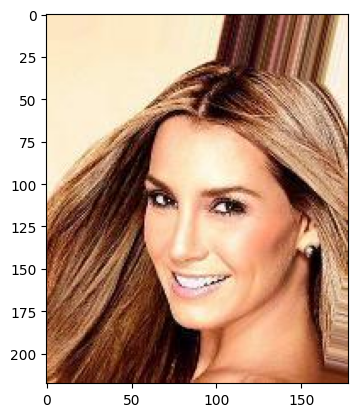

In [7]:
# Check
img = Image.open('C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\img_align_celeba\\000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape) # displays dimension of image
plt.imshow(img) # displays image

In [8]:
# (218, 178, 3)
INITIAL_HEIGHT = np.asarray(img, dtype=np.uint8).shape[0]
INITIAL_WIDTH = np.asarray(img, dtype=np.uint8).shape[1]

# Loading and Preprocessing of Inputs

Steps:
1. To rescale an input in the [0, 255] range to be in the [0, 1] range, you would pass scale=1./255.
2. RGB converted to grayscale (for greyscale_basemodel)
3. Centercrop to (178,178)
4. Resize to (128,128)

In [9]:
# PARAMETERS
BATCH_SIZE = 64
RESIZE_HEIGHT = 128
RESIZE_WIDTH = 128 
NUM_CLASSES = 2

In [7]:
csv_dir = 'C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\'

train_df=pd.read_csv(csv_dir+'celeba-gender-train.csv', dtype=str, index_col=[0])
valid_df=pd.read_csv(csv_dir+'celeba-gender-valid.csv', dtype=str, index_col=[0])
# Combine train and validation dataset as finetuning is not implemented for basemodel
fulltrain_df=pd.concat([train_df, valid_df])
test_df=pd.read_csv(csv_dir+'celeba-gender-test.csv', dtype=str, index_col=[0])

display(train_df.head())
display(train_df.shape)
display(valid_df.head())
display(valid_df.shape)
display(fulltrain_df.head())
display(fulltrain_df.shape)
display(test_df.head())
display(test_df.shape)

,image_id,Male,Partition
0,000001.jpg,0,0
1,000002.jpg,0,0
2,000003.jpg,1,0
3,000004.jpg,0,0
4,000005.jpg,0,0


(162770, 3)

,image_id,Male,Partition
162770,162771.jpg,0,1
162771,162772.jpg,1,1
162772,162773.jpg,0,1
162773,162774.jpg,1,1
162774,162775.jpg,0,1


(19867, 3)

,image_id,Male,Partition
0,000001.jpg,0,0
1,000002.jpg,0,0
2,000003.jpg,1,0
3,000004.jpg,0,0
4,000005.jpg,0,0


(182637, 3)

,image_id,Male,Partition
182637,182638.jpg,0,2
182638,182639.jpg,0,2
182639,182640.jpg,0,2
182640,182641.jpg,0,2
182641,182642.jpg,0,2


(19962, 3)

In [10]:
csv_dir = 'C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\'

train_df=pd.read_csv(csv_dir+'celeba-gender-train.csv', dtype=str, index_col=[0])
valid_df=pd.read_csv(csv_dir+'celeba-gender-valid.csv', dtype=str, index_col=[0])
# Combine train and validation dataset as finetuning is not implemented for basemodel
fulltrain_df=pd.concat([train_df, valid_df])
test_df=pd.read_csv(csv_dir+'celeba-gender-test.csv', dtype=str, index_col=[0])

display(train_df.head())
display(train_df.shape)
display(valid_df.head())
display(valid_df.shape)
display(fulltrain_df.head())
display(fulltrain_df.shape)
display(test_df.head())
display(test_df.shape)

,image_id,Male,Partition
0,000001.jpg,0,0
1,000002.jpg,0,0
2,000003.jpg,1,0
3,000004.jpg,0,0
4,000005.jpg,0,0


(162770, 3)

,image_id,Male,Partition
162770,162771.jpg,0,1
162771,162772.jpg,1,1
162772,162773.jpg,0,1
162773,162774.jpg,1,1
162774,162775.jpg,0,1


(19867, 3)

,image_id,Male,Partition
0,000001.jpg,0,0
1,000002.jpg,0,0
2,000003.jpg,1,0
3,000004.jpg,0,0
4,000005.jpg,0,0


(182637, 3)

,image_id,Male,Partition
182637,182638.jpg,0,2
182638,182639.jpg,0,2
182639,182640.jpg,0,2
182640,182641.jpg,0,2
182641,182642.jpg,0,2


(19962, 3)

In [11]:
# Custom Dataset for Images
# https://www.youtube.com/watch?v=q7ZuZ8ZOErE

celeba_dir = 'C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\img_align_celeba\\'

train_filepaths = train_df['image_id'].values
valid_filepaths = valid_df['image_id'].values
fulltrain_filepaths = fulltrain_df['image_id'].values
test_filepaths = test_df['image_id'].values

train_labels = train_df['Male'].values
valid_labels = valid_df['Male'].values
fulltrain_labels = fulltrain_df['Male'].values
test_labels = test_df['Male'].values

def generate_ds():
    
    # One hot encode label to a 2D tensor
    # https://www.tensorflow.org/api_docs/python/tf/one_hot
    # https://stackoverflow.com/questions/48851558/tensorflow-estimator-valueerror-logits-and-labels-must-have-the-same-shape
    #ds_train = tf.data.Dataset.from_tensor_slices((train_filepaths, tf.one_hot(train_labels, depth=NUM_CLASSES)))
    #ds_valid = tf.data.Dataset.from_tensor_slices((valid_filepaths, tf.one_hot(valid_labels, depth=NUM_CLASSES)))
    ds_fulltrain = tf.data.Dataset.from_tensor_slices((fulltrain_filepaths, tf.one_hot(fulltrain_labels, depth=NUM_CLASSES))) 
    ds_test = tf.data.Dataset.from_tensor_slices((test_filepaths, tf.one_hot(test_labels, depth=NUM_CLASSES)))

    return ds_fulltrain, ds_test

# tf.image 
# https://www.tensorflow.org/api_docs/python/tf/image
# tf.image.crop_to_bounding_box(image, offset_height, offset_width, target_height, target_width)
# https://stackoverflow.com/questions/54865717/tensorflow-crop-largest-central-square-region-of-image
def read_image(image_file, label):
    
    mode = 1 if GRAYSCALE == True else 3
    
    image = tf.io.read_file(celeba_dir+image_file)
    image = tf.image.decode_image(image, channels=mode, dtype=tf.float32) # Number of color channels for the decoded image.
    #image = image/255.0 # No need as rescale has been automatically done 
    
    # Centercrop image to obtain largest central square (178, 178)
    if INITIAL_HEIGHT > INITIAL_WIDTH:
        cropped_image = tf.image.crop_to_bounding_box(image, (INITIAL_HEIGHT - INITIAL_WIDTH) // 2, 0, INITIAL_WIDTH, INITIAL_WIDTH) 
    else:
        cropped_image = tf.image.crop_to_bounding_box(image, 0, (INITIAL_WIDTH - INITIAL_HEIGHT) // 2, INITIAL_HEIGHT, INITIAL_HEIGHT)
    
    # Resize image to (128, 128)
    resized_image = tf.image.resize(cropped_image, (RESIZE_HEIGHT, RESIZE_WIDTH))
    
    return resized_image, label

In [12]:
# Check
GRAYSCALE = True
checkimg, checklabel = read_image('000001.jpg', tf.one_hot(0, depth=NUM_CLASSES))
print("Min and max pixel values:", checkimg.numpy().min(), checkimg.numpy().max())
print(checkimg.shape)
print(checklabel)

Min and max pixel values: 8.473116e-05 0.98291665
(128, 128, 1)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)


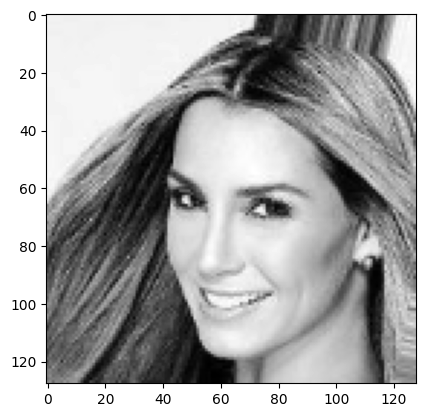

In [13]:
# For displaying a grayscale image set up the colormapping using the parameters cmap='gray'.
# https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.imshow.html
plt.imshow(checkimg, cmap = 'gray') # plt.cm.gray

In [14]:
gs_fulltrain, gs_test = generate_ds()

GRAYSCALE = True

gs_fulltrain = gs_fulltrain.map(read_image).batch(BATCH_SIZE)
gs_test = gs_test.map(read_image).batch(BATCH_SIZE)

In [15]:
rgb_fulltrain, rgb_test = generate_ds()

GRAYSCALE = False

rgb_fulltrain = rgb_fulltrain.map(read_image).batch(BATCH_SIZE)
rgb_test = rgb_test.map(read_image).batch(BATCH_SIZE)

In [16]:
### Not used due to depreciation and inability to support centercrop. ###

# Tutorial on Keras flow_from_dataframe
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#fit
# https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

# celeba_dir = 'C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\img_align_celeba'

# def generate_ds():
    
#     CMode = "grayscale" if GRAYSCALE == True else "rgb"

#     datagen_train = ImageDataGenerator(rescale=1./255.)
#     datagen_valid = ImageDataGenerator(rescale=1./255.)
#     datagen_test = ImageDataGenerator(rescale=1./255.)

#     train_generator=datagen_train.flow_from_dataframe(
#         dataframe=train_df,
#         directory=celeba_dir,
#         x_col="image_id",
#         y_col="Male",
#         batch_size=BATCH_SIZE,
#         seed=SEED,
#         shuffle=True,
#         class_mode="categorical",
#         color_mode=CMode,
#         target_size=(RESIZE_HEIGHT,RESIZE_WIDTH))

#     valid_generator=datagen_valid.flow_from_dataframe(
#         dataframe=valid_df,
#         directory=celeba_dir,
#         x_col="image_id",
#         y_col="Male",
#         batch_size=BATCH_SIZE,
#         seed=SEED,
#         shuffle=True,
#         class_mode="categorical",
#         color_mode=CMode,
#         target_size=(RESIZE_HEIGHT,RESIZE_WIDTH))

#     test_generator=datagen_test.flow_from_dataframe(
#         dataframe=test_df,
#         directory=celeba_dir,
#         x_col="image_id",
#         y_col="Male",
#         batch_size=BATCH_SIZE,
#         seed=SEED,
#         shuffle=False,
#         class_mode="categorical",
#         color_mode=CMode,
#         target_size=(RESIZE_HEIGHT,RESIZE_WIDTH))
    
#     return train_generator, valid_generator, test_generator

# Model 

In [17]:
# Architecture
NUM_CLASSES = 2
RGB_INPUT = (RESIZE_HEIGHT, RESIZE_WIDTH, 3)
GS_INPUT = (RESIZE_HEIGHT, RESIZE_WIDTH, 1)

## With Grayscale

In [18]:
# Github source code for tf.keras.applications.resnet
#https://github.com/keras-team/keras/blob/v2.10.0/keras/applications/resnet.py#L499-L533

from keras import backend
from keras.applications import imagenet_utils
from keras.engine import training
from keras.layers import VersionAwareLayers
from keras.utils import data_utils
from keras.utils import layer_utils
from keras_applications.imagenet_utils import _obtain_input_shape

def block1(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    """A residual block.
    Args:
      x: input tensor.
      filters: integer, filters of the bottleneck layer.
      kernel_size: default 3, kernel size of the bottleneck layer.
      stride: default 1, stride of the first layer.
      conv_shortcut: default True, use convolution shortcut if True,
          otherwise identity shortcut.
      name: string, block label.
    Returns:
      Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    if conv_shortcut:
        shortcut = layers.Conv2D(
            4 * filters, 1, strides=stride, name=name + "_0_conv"
        )(x)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, epsilon=1.001e-5, name=name + "_0_bn"
        )(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, strides=stride, name=name + "_1_conv")(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name=name + "_1_bn"
    )(x)
    x = layers.Activation("relu", name=name + "_1_relu")(x)

    x = layers.Conv2D(
        filters, kernel_size, padding="SAME", name=name + "_2_conv"
    )(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name=name + "_2_bn"
    )(x)
    x = layers.Activation("relu", name=name + "_2_relu")(x)

    x = layers.Conv2D(4 * filters, 1, name=name + "_3_conv")(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name=name + "_3_bn"
    )(x)

    x = layers.Add(name=name + "_add")([shortcut, x])
    x = layers.Activation("relu", name=name + "_out")(x)
    return x


def stack1(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.
    Args:
      x: input tensor.
      filters: integer, filters of the bottleneck layer in a block.
      blocks: integer, blocks in the stacked blocks.
      stride1: default 2, stride of the first layer in the first block.
      name: string, stack label.
    Returns:
      Output tensor for the stacked blocks.
    """
    x = block1(x, filters, stride=stride1, name=name + "_block1")
    for i in range(2, blocks + 1):
        x = block1(
            x, filters, conv_shortcut=False, name=name + "_block" + str(i)
        )
    return x

In [19]:
layers = None

def ResNet(
    stack_fn,
    preact,
    use_bias,
    model_name="resnet",
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs
):
    """Instantiates the ResNet, ResNetV2, and ResNeXt architecture.
    Args:
      stack_fn: a function that returns output tensor for the
        stacked residual blocks.
      preact: whether to use pre-activation or not
        (True for ResNetV2, False for ResNet and ResNeXt).
      use_bias: whether to use biases for convolutional layers or not
        (True for ResNet and ResNetV2, False for ResNeXt).
      model_name: string, model name.
      include_top: whether to include the fully-connected
        layer at the top of the network.
      weights: one of `None` (random initialization),
        'imagenet' (pre-training on ImageNet),
        or the path to the weights file to be loaded.
      input_tensor: optional Keras tensor
        (i.e. output of `layers.Input()`)
        to use as image input for the model.
      input_shape: optional shape tuple, only to be specified
        if `include_top` is False (otherwise the input shape
        has to be `(224, 224, 3)` (with `channels_last` data format)
        or `(3, 224, 224)` (with `channels_first` data format).
        It should have exactly 3 inputs channels.
      pooling: optional pooling mode for feature extraction
        when `include_top` is `False`.
        - `None` means that the output of the model will be
            the 4D tensor output of the
            last convolutional layer.
        - `avg` means that global average pooling
            will be applied to the output of the
            last convolutional layer, and thus
            the output of the model will be a 2D tensor.
        - `max` means that global max pooling will
            be applied.
      classes: optional number of classes to classify images
        into, only to be specified if `include_top` is True, and
        if no `weights` argument is specified.
      classifier_activation: A `str` or callable. The activation function to use
        on the "top" layer. Ignored unless `include_top=True`. Set
        `classifier_activation=None` to return the logits of the "top" layer.
        When loading pretrained weights, `classifier_activation` can only
        be `None` or `"softmax"`.
      **kwargs: For backwards compatibility only.
    Returns:
      A `keras.Model` instance.
    """
    global layers
    if "layers" in kwargs:
        layers = kwargs.pop("layers")
    else:
        layers = VersionAwareLayers()
    if kwargs:
        raise ValueError("Unknown argument(s): %s" % (kwargs,))
    if not (weights in {"imagenet", None} or tf.io.gfile.exists(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), `imagenet` "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded."
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            'If using `weights` as `"imagenet"` with `include_top`'
            " as true, `classes` should be 1000"
        )

    # Determine proper input shape
    ### Input shape changed to 1 channel for grayscale images ###
    input_shape = GS_INPUT if GRAYSCALE == True else RGB_INPUT
    
    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1
    
    ### Not used as preprocessing is done on datasets instead ###
    ### Preprocessing layers added ###
    #x = tf.keras.layers.CenterCrop(CENTERCROP_HEIGHT, CENTERCROP_WIDTH, name="centercrop1")(img_input)
    #x = tf.keras.layers.Resizing(RESIZE_HEIGHT, RESIZE_WIDTH, name="resize1")(x)
    
    x = layers.ZeroPadding2D(padding=((3, 3)), name="conv1_pad")(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=use_bias, name="conv1_conv")(x)

    if not preact:
        x = layers.BatchNormalization(
            axis=bn_axis, epsilon=1.001e-5, name="conv1_bn"
        )(x)
        x = layers.Activation("relu", name="conv1_relu")(x)

    x = layers.ZeroPadding2D(padding=((1, 1)), name="pool1_pad")(x)
    x = layers.MaxPooling2D(3, strides=2, name="pool1_pool")(x)

    x = stack_fn(x)

    if preact:
        x = layers.BatchNormalization(
            axis=bn_axis, epsilon=1.001e-5, name="post_bn"
        )(x)
        x = layers.Activation("relu", name="post_relu")(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        imagenet_utils.validate_activation(classifier_activation, weights)
        x = layers.Dense(
            classes, activation=classifier_activation, name="predictions"
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D(name="max_pool")(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = layer_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = training.Model(inputs, x, name=model_name)

    # Load weights.
    ### Loading of imagenet weights removed. ###
    if weights is not None:
        model.load_weights(weights)

    return model

In [20]:
def ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    **kwargs
):
    """Instantiates the ResNet50 architecture."""

    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name="conv2")
        x = stack1(x, 128, 4, name="conv3")
        x = stack1(x, 256, 6, name="conv4")
        return stack1(x, 512, 3, name="conv5")

    return ResNet(
        stack_fn,
        False,
        True,
        "resnet50",
        include_top,
        weights,
        input_tensor,
        input_shape,
        pooling,
        classes,
        **kwargs
    )

In [21]:
GRAYSCALE = True

grayscale_basemodel = ResNet50(
    include_top=True,
    weights=None, # Pretraining on CelebA
    input_tensor=None,
    pooling=None,
    classes=2,
    classifier_activation="softmax"
)

In [22]:
grayscale_basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

## RGB

In [23]:
GRAYSCALE = False

basemodel = ResNet50(
    include_top=True,
    weights=None, # Pretraining on CelebA
    input_tensor=None,
    pooling=None,
    classes=2,
    classifier_activation="softmax"
)

In [24]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

# Training

In [25]:
# SETTINGS
LEARNING_RATE = 0.001 # default of Adam optimizer
NUM_EPOCHS = 3 # 1 epoch takes about 6-7 hours!

In [26]:
gs_checkpoint_path = "C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\ckpt\\gs_best"
rgb_checkpoint_path = "C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\ckpt\\rgb_best"

# Create a callback that saves the model's weights
gs_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=gs_checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_freq='epoch',
                                                 verbose=1)

rgb_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=rgb_checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_freq='epoch',
                                                 verbose=1)

In [27]:
grayscale_basemodel.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE),
    loss="binary_crossentropy", metrics=["accuracy"])

basemodel.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE),
    loss="binary_crossentropy", metrics=["accuracy"])

In [28]:
# No need to run again
# gs_history = grayscale_basemodel.fit(gs_fulltrain,
#                     validation_data=gs_test,
#                     epochs=NUM_EPOCHS,
#                     callbacks=[gs_cp_callback]
# )

In [29]:
# Not ran due to constraints in resources e.g. Time, CPU
# rgb_history = basemodel.fit(rgb_fulltrain,
#                     validation_data=rgb_test,
#                     epochs=NUM_EPOCHS,
#                     callbacks=[rgb_cp_callback]
# )

# Evaluate Model

In [30]:
# Test accuracy using the best epoch
grayscale_basemodel.load_weights(gs_checkpoint_path)
eval_result = grayscale_basemodel.evaluate(gs_test)
print("Validation accuracy from the best epoch:", eval_result[1])

312/312 [==============================] - 596s 2s/step - loss: 0.1116 - accuracy: 0.9587
Validation accuracy from the best epoch: 0.9586714506149292
